<a href="https://colab.research.google.com/github/KrDevanshu06/Summer-Analytics-2025/blob/main/logistic_model_ndvi_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Summer Analytics 2025 – First Hackathon

Welcome to the inaugural hackathon of **Summer Analytics 2025**, hosted by the *Consulting & Analytics Club* in collaboration with *GeeksforGeeks*. This challenge focuses on applying logistic regression to a real-world, remote sensing problem: **classifying land cover types using NDVI time-series data** derived from satellite imagery.

## Objective

Your task is to develop a robust logistic regression model capable of predicting land cover classes—such as Water, Farm, Forest, and more—based on 27 temporal NDVI observations per location. The challenge lies in effectively handling **noisy, missing, and seasonally varying data** to ensure strong generalization to clean, unseen samples.

## Key Highlights

- **Data Complexity:** Noisy inputs, temporal patterns, and partial observations.
- **Focus on ML Fundamentals:** Logistic regression only—no ensemble methods or deep learning.
- **Fair Evaluation:** Public leaderboard reflects noisy test data; private leaderboard uses clean labels for true model performance.

By the end of this notebook, we will explore a complete ML pipeline—from data preprocessing and feature engineering to model training, evaluation, and final submission—all under the constraints of a single, interpretable classifier.

Let’s begin!


# **Importing required libraries**

Imports essential libraries for data handling (`pandas`, `numpy`), visualization (`matplotlib`, `seaborn`), and machine learning tasks such as model building, preprocessing, and evaluation (`scikit-learn`).


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Loading datasets and checking structure

Loads the training and test datasets using `pandas`, prints their shapes, and displays the class distribution in the training data to understand the dataset size and balance.


In [31]:
train = pd.read_csv("hacktrain.csv")
test = pd.read_csv("hacktest.csv")

print("Train shape:", train.shape)
print("Test shape:", test.shape)
print(train['class'].value_counts())

Train shape: (8000, 30)
Test shape: (2845, 29)
class
forest        6159
farm           841
impervious     669
grass          196
water          105
orchard         30
Name: count, dtype: int64


# Visualizing class distribution

Creates a bar plot of class frequencies in the training data to visualize class imbalance and distribution.


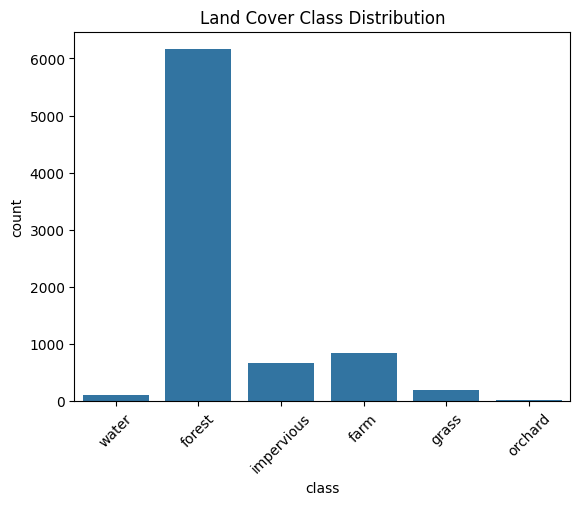

In [19]:
sns.countplot(data=train, x='class')
plt.title('Land Cover Class Distribution')
plt.xticks(rotation=45)
plt.show()


# Handling missing NDVI values

Identifies NDVI-related columns and fills missing values with the respective column means in both training and test datasets to ensure data consistency.


In [32]:
ndvi_columns = [col for col in train.columns if '_N' in col]

train[ndvi_columns] = train[ndvi_columns].fillna(train[ndvi_columns].mean())
test[ndvi_columns] = test[ndvi_columns].fillna(test[ndvi_columns].mean())


# Smoothing NDVI values

Applies a rolling mean with a defined window (default = 3) across NDVI time series to reduce noise and smooth temporal variations in both training and test datasets.


In [21]:
def smooth_ndvi(df, ndvi_cols, window=3):
    return df[ndvi_cols].rolling(window=window, axis=1, min_periods=1).mean()

train[ndvi_columns] = smooth_ndvi(train, ndvi_columns)
test[ndvi_columns] = smooth_ndvi(test, ndvi_columns)


<ipython-input-21-883100936>:2: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  return df[ndvi_cols].rolling(window=window, axis=1, min_periods=1).mean()
<ipython-input-21-883100936>:2: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  return df[ndvi_cols].rolling(window=window, axis=1, min_periods=1).mean()


# Extracting NDVI-based statistical and temporal features

Generates summary statistics (mean, std, max, min, range) for each sample's NDVI time series, computes quarterly NDVI averages, and calculates first-order differences to capture temporal change patterns.


In [22]:
for df in [train, test]:
    df['ndvi_mean'] = df[ndvi_columns].mean(axis=1)
    df['ndvi_std'] = df[ndvi_columns].std(axis=1)
    df['ndvi_max'] = df[ndvi_columns].max(axis=1)
    df['ndvi_min'] = df[ndvi_columns].min(axis=1)
    df['ndvi_range'] = df['ndvi_max'] - df['ndvi_min']

    # Quarterly averages (7 each)
    df['ndvi_q1_mean'] = df[ndvi_columns[:7]].mean(axis=1)
    df['ndvi_q2_mean'] = df[ndvi_columns[7:14]].mean(axis=1)
    df['ndvi_q3_mean'] = df[ndvi_columns[14:21]].mean(axis=1)
    df['ndvi_q4_mean'] = df[ndvi_columns[21:]].mean(axis=1)

    # Derivatives
    df['ndvi_diff_mean'] = df[ndvi_columns].diff(axis=1).mean(axis=1)
    df['ndvi_diff_std'] = df[ndvi_columns].diff(axis=1).std(axis=1)


# Encoding class labels

Uses `LabelEncoder` to convert categorical land cover class labels into numeric format for model training.


In [23]:
le = LabelEncoder()
train['class_encoded'] = le.fit_transform(train['class'])


# Defining final feature set

Combines raw NDVI values with engineered statistical and temporal features to create the final set of input features for model training.


In [24]:
final_features = ndvi_columns + [
    'ndvi_mean', 'ndvi_std', 'ndvi_max', 'ndvi_min', 'ndvi_range',
    'ndvi_q1_mean', 'ndvi_q2_mean', 'ndvi_q3_mean', 'ndvi_q4_mean',
    'ndvi_diff_mean', 'ndvi_diff_std'
]


# Feature scaling and target assignment

Applies standard scaling to the final feature set to normalize the data and assigns the encoded class labels as the target variable for training.


In [25]:
scaler = StandardScaler()
X = scaler.fit_transform(train[final_features])
X_test = scaler.transform(test[final_features])
y = train['class_encoded']


# Splitting data into training and validation sets

Splits the data into training and validation subsets using an 80-20 ratio with stratification to maintain class distribution.


In [26]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


# Training logistic regression model

Initializes and trains a multinomial logistic regression model with balanced class weights and increased iteration limit to handle multiclass classification effectively.


In [27]:
model = LogisticRegression(
    max_iter=1000,
    multi_class='multinomial',
    solver='lbfgs',
    class_weight='balanced',
    random_state=42
)

model.fit(X_train, y_train)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(class_weight='balanced', max_iter=1000,
                   multi_class='multinomial', random_state=42)

# Evaluating model performance on validation set

Generates predictions on the validation data and evaluates performance using accuracy, classification report, and a confusion matrix to visualize prediction quality across classes.


Validation Accuracy: 0.7775
              precision    recall  f1-score   support

        farm       0.50      0.64      0.56       168
      forest       0.98      0.80      0.88      1232
       grass       0.25      0.67      0.37        39
  impervious       0.77      0.81      0.79       134
     orchard       0.06      0.83      0.12         6
       water       0.29      0.76      0.42        21

    accuracy                           0.78      1600
   macro avg       0.47      0.75      0.52      1600
weighted avg       0.88      0.78      0.82      1600



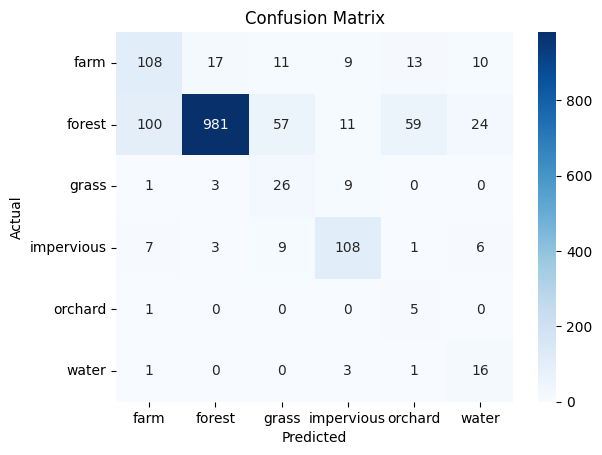

In [28]:
val_preds = model.predict(X_val)

print("Validation Accuracy:", accuracy_score(y_val, val_preds))
print(classification_report(y_val, val_preds, target_names=le.classes_))

cm = confusion_matrix(y_val, val_preds)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


# Generating predictions on test data and saving submission

Applies the trained model to the test set, decodes predicted class labels, and saves the results in a submission file formatted as required.


In [29]:
test_preds = model.predict(X_test)
test['class'] = le.inverse_transform(test_preds)

submission = test[['ID', 'class']]
submission.to_csv("submission.csv", index=False)
print("Submission file saved as submission.csv")


Submission file saved as submission.csv
